# Overview

Data science isn't just for predicting ad-clicks-it's also useful for social impact! This is a case study from a machine learning competition on DrivenData. We'll explore a problem related to school district budgeting. By building a model to automatically classify items in a school's budget, it makes it easier and faster for schools to compare their spending with other schools. We'll begin by building a baseline model that is a simple, first-pass approach. In particular, we'll do some natural language processing to prepare the budgets for modeling. Next, we'll have the opportunity to try our own techniques and see how they compare to participants from the competition. Finally, We'll see how the winner was able to combine a number of expert techniques to build the most accurate model.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

# Exploring the raw data

We'll expore the problem we'll be solving.  How do we accurately classify line-items in a school budget based on what that money is being used for? We will explore the raw text and numeric values in the dataset, both quantitatively and visually. And We'll explore how to measure success when trying to predict class labels for each row of the dataset.

## Introducing the challenge

- Learn from the expert who won DrivenData's challenge
  - Natural language processing
  - Feature engineering
  - Efciency boosting hashing tricks
- Use data to have a social impact
- Budgets for schools are huge, complex, and not standardized
  - Hundreds of hours each year are spent manually labelling
- **Goal**: Build a machine learning algorithm that can automate the process 
- Budget data
  - **Line-item**: "Algebra books for 8th grade students"
  - **Labels**: "Textbooks", "Math", "Middle School"
- This is a supervised learning problem

> ### Over 100 target variables!
- This is a classication problem

> ### How we can help
- Predictions will be probabilities for each label
- Supervised Learning, because the model will be trained using labeled examples.
- Using correctly labeled budget line items to train means this is a supervised learning problem.

our goal is to correctly label budget line items by training a supervised model to predict the probability of each possible label, taking most probable label as the correct label. This is Classification, because predicted probabilities will be used to select a label class. Specifically, we have ourselves a multi-class-multi-label classification problem (quite a mouthful!), because there are 9 broad categories that each take on many possible sub-label instances.

## Exploring the data




### Loading the data

Now it's time to check out the dataset! we'll use pandas (which has been pre-imported as `pd`) to load our data into a DataFrame and then do some Exploratory Data Analysis (EDA) of it.

The training data is available as `TrainingData.csv`. Our first task is to load it into a DataFrame in the IPython Shell using `pd.read_csv(`) along with the keyword argument `index_col=0`.

In [3]:
train = pd.read_csv("datasets/TrainingData.csv", index_col=0)
train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplemental *,...,Non-Certificated Salaries And Wages,NaN,NaN,Care and Upkeep of Building Services,NaN,NaN,-8291.86,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I CARRYOVER
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating,REPAIR AND MAINTENANCE SERVICES,...,NaN,ADMIN. SERVICES,NaN,STUDENT TRANSPORT SERVICE,NaN,NaN,618.29,PUPIL TRANSPORTATION,General Fund,NaN
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,49768.82,Instruction - Regular,General Purpose School,NaN
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,General Supplies,...,General Supplies,NaN,NaN,Instruction,Instruction And Curriculum,NaN,-1.02,"""Title I, Part A Schoolwide Activities Related...",General Operating Fund,NaN
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Other Community Services *,NaN,NaN,2304.43,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I PI+HOMELESS


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 198 to 101861
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Function                1560 non-null   object 
 1   Use                     1560 non-null   object 
 2   Sharing                 1560 non-null   object 
 3   Reporting               1560 non-null   object 
 4   Student_Type            1560 non-null   object 
 5   Position_Type           1560 non-null   object 
 6   Object_Type             1560 non-null   object 
 7   Pre_K                   1560 non-null   object 
 8   Operating_Status        1560 non-null   object 
 9   Object_Description      1461 non-null   object 
 10  Text_2                  382 non-null    object 
 11  SubFund_Description     1183 non-null   object 
 12  Job_Title_Description   1131 non-null   object 
 13  Text_3                  296 non-null    object 
 14  Text_4                  193 non-null

In [5]:
train.tail()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
344986,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,27.04000,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION
384803,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,EMPLOYEE BENEFITS,...,NaN,PERSONNEL-PAID LEAVE,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,NaN,STAFF SERVICES,NaN,CENTRAL
224382,Substitute Compensation,Instruction,School Reported,School,Special Education,Substitute,Substitute Compensation,NO_LABEL,PreK-12 Operating,OTHER PERSONAL SERVICES,...,NaN,School,0.0,EXCEPTIONAL,NaN,NaN,200.39000,NaN,GENERAL FUND,NaN
305347,Facilities & Maintenance,O&M,Leadership & Management,Non-School,Gifted,Custodian,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Extra Duty Pay/Overtime For Support Personnel,...,Extra Duty Pay/Overtime For Support Personnel,Unallocated,NaN,Facilities Maintenance And Operations,Gifted And Talented,ANY CUS WHO IS NOT A SUPER,5.29000,Gifted And Talented,General Operating Fund,ADDL REGULAR PAY-NOT SMOOTHED
101861,Teacher Compensation,Instruction,School Reported,School,Poverty,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF REGULAR EMPLOYEES,...,NaN,NaN,NaN,TITLE I,NaN,PROFESSIONAL-INSTRUCTIONAL,1575.03504,GENERAL ELEMENTARY EDUCATION,NaN,REGULAR INSTRUCTION


Some of the column names correspond to **features** - descriptions of the budget items - such as the `Job_Title_Description` column. The values in this column tell us if a budget item is for a teacher, custodian, or other employee.

Some columns correspond to the budget item **labels** we will be trying to predict with our model. For example, the `Object_Type` column describes whether the budget item is related classroom supplies, salary, travel expenses, etc.

* 1560 rows, 
* 25 columns, 
* 1131 non-null entries in `Job_Title_Description`

Looks like there are a lot of missing values. We will need to keep your eyes on those.

### Summarizing the data

We'll continue the EDA by computing summary statistics for the numeric data in the dataset. 

There are two numeric columns, called `FTE` and `Total`.

* `FTE`: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.
* `Total`: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

In [6]:
train.describe()

,FTE,Total
count,449.000000,1.542000e+03
mean,0.493532,1.446867e+04
std,0.452844,7.916752e+04
min,-0.002369,-1.044084e+06
25%,0.004310,1.108111e+02
50%,0.440000,7.060299e+02
75%,1.000000,5.347760e+03
max,1.047222,1.367500e+06


After printing summary statistics for the numeric data, we will plot a histogram of the non-null `FTE` column to see the distribution of part-time and full-time employees in the dataset.

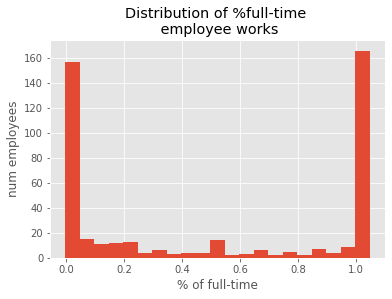

In [8]:
# Create the histogram
plt.hist(train.FTE.dropna(), bins=int(np.sqrt(len(train.FTE.dropna()))))

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Display the histogram
plt.show()

The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees.

## Looking at the datatypes

> ### Encode labels as categories
- ML algorithms work on numbers, not strings
  - Need a numeric representation of these strings
- Strings can be slow compared to numbers
- In pandas, `category` dtype encodes categorical data numerically
  - Can speed up code

> ### Dummy variable encoding
- Also called a binary indicator representation

> ### Lambda functions
- Alternative to `def` syntax
- Easy way to make simple, one-line functions

> ### Encode labels as categories
- In the budget data, there are multiple columns that need to bemade categorical


### Exploring datatypes in pandas



In [9]:
train.dtypes.value_counts()

object     23
float64     2
dtype: int64

### Encode the labels as categorical variables

our ultimate goal is to predict the probability that a certain label is attached to a budget line item. we just saw that many columns in our data are the inefficient `object` type. Does this include the labels we're trying to predict? Let's find out!

In [10]:
LABELS = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

There are 9 columns of labels in the dataset. Each of these columns is a category that has [many possible values it can take](https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list). The 9 labels have been loaded into a list called `LABELS`.

In [11]:
train[LABELS].dtypes

Function            object
Use                 object
Sharing             object
Reporting           object
Student_Type        object
Position_Type       object
Object_Type         object
Pre_K               object
Operating_Status    object
dtype: object

every label is encoded as an `object` datatype. Because category datatypes are [much more efficient](http://matthewrocklin.com/blog/work/2015/06/18/Categoricals) our task is to convert the labels to `category` types using the `.astype()` method.

> Note: `.astype()` only works on a pandas Series. Since we are working with a pandas DataFrame, we'll need to use the `.apply()` method and provide a lambda function called `categorize_label` that applies `.astype()` to each column, `x`.

In [12]:
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype("category")

# Convert df[LABELS] to a categorical type
train[LABELS] = train[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
train[LABELS].dtypes

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object

### Counting unique labels

there are over 100 unique labels. We will explore this fact by counting and plotting the number of unique values for each category of label.

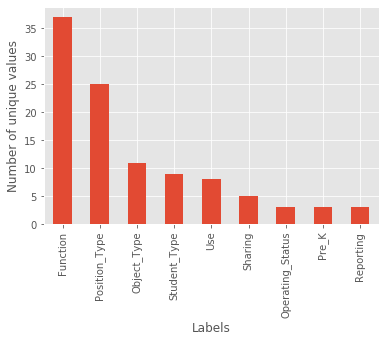

In [16]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = train[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.sort_values(ascending=False).plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

That's a lot of labels to work with. How will you measure success with these many labels? 

## How do we measure success?

- Accuracy can be misleading when classes are imbalanced. 
- **Legitimate email**: 99%, Spam: 1%
- Model that never predicts spam will be 99% accurate!
- **Metric used in this problem**: log loss
  - It is a loss function
  - Measure of error
  - Want to minimize the error (unlike accuracy)

> ### Log loss binary classication
- Log loss for binary classication
$$
logloss = \frac{1}{N}\sum_{i=1}^{N}(y_i\log(p_i)+(1-y_i)\log(1-p_i))
$$
- Actual value: y = {1=yes, 0=no}
- Prediction (probability that the value is 1): p

> ### Log loss binary classication: example
$$
logloss_{N=1} = y\log(p) + (1-y)\log(1-p)
$$
- True label: 0
- Model confidently predicts 1 (with p = 0.9)
$$
\begin{split}
logloss & = (1-y)\log(1-p)\\
& = \log(1-0.9)\\
& = log(0.1)\\
& = 2.30
\end{split}
$$

$logloss_{N=1} = y\log(p) + (1-y)\log(1-p)$
- True label = 1
- Model predicts 0 (with p = 0.50)
- Log loss = 0.69
- Better to be less confident than confident and wrong


### Penalizing highly confident wrong answers

log loss provides a steep penalty for predictions that are both wrong and confident, i.e., a high probability is assigned to the incorrect class.

### Computing log loss with NumPy



In [17]:
def compute_log_loss(predicted, actual, eps=1e-14):
    """ Computes the logarithmic loss between `predicted` and `actual` when these are 1D arrays.
    """
    predicted = np.clip(predicted, eps, 1 - eps)
    
    return -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

To see how the log loss metric handles the trade-off between accuracy and confidence, we will use some sample data generated with NumPy and compute the log loss using the provided function `compute_log_loss()`.

In [18]:
actual_labels = np.array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
correct_confident = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.05, 0.05, 0.05, 0.05, 0.05])
correct_not_confident = np.array([0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35])
wrong_not_confident = np.array([0.35, 0.35, 0.35, 0.35, 0.35, 0.65, 0.65, 0.65, 0.65, 0.65])
wrong_confident = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.95, 0.95, 0.95, 0.95, 0.95])


In [19]:
# Compute and print log loss for 1st case
correct_confident_loss = compute_log_loss(correct_confident, actual_labels)
print("Log loss, correct and confident: {}".format(correct_confident_loss)) 



Log loss, correct and confident: 0.05129329438755058


In [20]:
# Compute log loss for 2nd case
correct_not_confident_loss = compute_log_loss(correct_not_confident, actual_labels)
print("Log loss, correct and not confident: {}".format(correct_not_confident_loss)) 



Log loss, correct and not confident: 0.4307829160924542


In [21]:
# Compute and print log loss for 3rd case
wrong_not_confident_loss = compute_log_loss(wrong_not_confident, actual_labels)
print("Log loss, wrong and not confident: {}".format(wrong_not_confident_loss)) 



Log loss, wrong and not confident: 1.049822124498678


In [22]:
# Compute and print log loss for 4th case
wrong_confident_loss = compute_log_loss(wrong_confident, actual_labels)
print("Log loss, wrong and confident: {}".format(wrong_confident_loss)) 



Log loss, wrong and confident: 2.9957322735539904


In [23]:
# Compute and print log loss for actual labels
actual_labels_loss = compute_log_loss(actual_labels, actual_labels)
print("Log loss, actual labels: {}".format(actual_labels_loss)) 


Log loss, actual labels: 9.99200722162646e-15


Log loss penalizes highly confident wrong answers much more than any other type. This will be a good metric to use on our models. 